In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [2]:
import torch
import numpy as np
import random

def seed_everything():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

## Load dataset

In [3]:
from personalized_nlp.datasets.emotions.emotions import EmotionsDataModule

## Import models

In [4]:
from personalized_nlp.models.baseline import Net
from personalized_nlp.models.onehot import NetOneHot
from personalized_nlp.models.human_bias import HumanBiasNet
from personalized_nlp.models.bias import AnnotatorBiasNet
from personalized_nlp.models.annotator import AnnotatorEmbeddingNet
from personalized_nlp.models.annotator_word import AnnotatorWordEmbeddingNet

from personalized_nlp.learning.train import train_test
from personalized_nlp.utils.metrics import evaluate_classification, evaluate_regression, get_result_dataframe
from personalized_nlp.settings import STORAGE_DIR

import pickle


## Train model

In [6]:
seed_everything()

results = []
regression = True

for embeddings_type in ['deberta']:
#for embeddings_type in ['xlmr', 'bert', 'deberta']:
    data_module = EmotionsDataModule(embeddings_type=embeddings_type, normalize=regression,
                                    batch_size=1000)
    data_module.prepare_data()
    data_module.setup()
    data_module.compute_word_stats(
        min_word_count=200,
        min_std=0.0,
        words_per_text=100
    )
    model_type = 'embedding'
    embedding_dim = 50
    output_dim = len(data_module.class_dims)
    text_embedding_dim = data_module.text_embedding_dim

    model = AnnotatorEmbeddingNet(output_dim=output_dim, text_embedding_dim=text_embedding_dim, word_num=data_module.words_number, 
                                  annotator_num=data_module.annotators_number, dp=0.0, dp_emb=0.25, 
                                  embedding_dim=embedding_dim, hidden_dim=100)

    test_predictions, true_labels, model, timings = train_test(data_module, model, epochs=10, lr=0.008, regression=regression,
                                                      use_cuda=False)


wandb: Currently logged in as: satyrr (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | AnnotatorEmbeddingNet | 575 K 
1 | metrics | ModuleDict            | 0     
--------------------------------------------------
575 K     Trainable params
0         Non-trainable params
575 K     Total params
2.304     Total estimated model params size (MB)


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.06038118898868561,
 'test_r2_OCZEKIWANIE': 0.36848628520965576,
 'test_r2_POBUDZENIE EMOCJONALNE': 0.4087772071361542,
 'test_r2_RADOŚĆ': 0.4208076000213623,
 'test_r2_SMUTEK': 0.36561185121536255,
 'test_r2_STRACH': 0.34536805748939514,
 'test_r2_WSTRĘT': 0.3287059962749481,
 'test_r2_ZASKOCZENIE': 0.3174651265144348,
 'test_r2_ZAUFANIE': 0.3541339039802551,
 'test_r2_ZNAK EMOCJI': 0.15514685213565826,
 'test_r2_ZŁOŚĆ': 0.3602287471294403,
 'test_r2_mean': 0.34247320890426636}
--------------------------------------------------------------------------------



TypeError: cannot unpack non-iterable NoneType object

## Embeddings

In [7]:
import pandas as pd
from sklearn.manifold import TSNE

In [9]:
model_annotator_embeddings = model.annotator_embeddings.weight.data.cpu().numpy()[1:]
model_annotator_embeddings.shape

tsne = TSNE(2)
annotator_embeddings_2d = tsne.fit_transform(model_annotator_embeddings)

In [10]:
annotators_embeddings_df = pd.DataFrame(annotator_embeddings_2d)
annotators_embeddings_df.columns = ['x', 'y']
annotators_embeddings_df['annotator_id'] = data_module.annotator_biases.index.values

In [11]:
annotations_df = data_module.annotations

In [12]:
annotator_stats = annotations_df.groupby('annotator_id').agg(['mean', 'std']).fillna(0).reset_index()
annotator_stats.columns = annotator_stats.columns.map('_'.join)
annotator_stats['annotator_id'] = annotator_stats['annotator_id_']
annotators_embeddings_df = annotators_embeddings_df.merge(annotator_stats, on='annotator_id')

In [13]:
emotion_columns = data_module.annotation_column

emotion_columns_std = [col + '_std' for col in emotion_columns]
emotion_columns_mean = [col + '_mean' for col in emotion_columns]
annotations_counts = annotations_df.annotator_id.value_counts().reset_index()
annotations_counts.columns = ['annotator_id_', 'total_count']

annotators_embeddings_df['total_std'] = annotators_embeddings_df.loc[:, emotion_columns_std].mean(axis=1)
annotators_embeddings_df['total_mean'] = annotators_embeddings_df.loc[:, emotion_columns_mean].mean(axis=1)
annotators_embeddings_df = annotators_embeddings_df.merge(annotations_counts)

In [14]:
annotators_embeddings_df = annotators_embeddings_df[annotators_embeddings_df.total_count > 20]
annotators_embeddings_df

x          y  annotator_id  annotator_id_   text_id_mean  \
1     25.170172 -25.180529         42100          42100  183747.680000   
3      5.491185  44.629345         59473          59473  185533.860000   
4     -3.566735  21.421902         72645          72645  185876.150000   
5     -6.407723 -35.031574         85085          85085  181371.222222   
6    -27.505255  -8.846148         87897          87897  186553.140000   
...         ...        ...           ...            ...            ...   
5157 -23.386604 -19.122019     988447815      988447815  179127.580000   
5158  13.219597 -15.897468     988447820      988447820  185798.070000   
5159  21.657709 -52.325851     988447826      988447826  185390.430000   
5160  31.996862 -25.950933     988447943      988447943  185570.280000   
5161  -0.227244   5.599268     988447952      988447952  185355.760000   

       text_id_std  OCZEKIWANIE_mean  OCZEKIWANIE_std  \
1     59569.322472          0.220000         0.352252   
3     62251.127814          0.050000         0.123718   
4     61741.593346          0.332500         0.246324   
5     58630.525818          0.425926         0.284325   
6     61517.353757          0.150000         0.248734   
...            ...               ...              ...   
5157  58127.702866          0.500000         0.276642   
5158  61721.399122          0.227500         0.353723   
5159  61901.535393          0.437500         0.366486   
5160  62046.924839          0.227500         0.163203   
5161  61963.808154          0.027500         0.086274   

      POBUDZENIE EMOCJONALNE_mean  POBUDZENIE EMOCJONALNE_std  ...  \
1                        0.565000                    0.363550  ...   
3                        0.065000                    0.110772  ...   
4                        0.270000                    0.226635  ...   
5                        0.453704                    0.196570  ...   
6                        0.975000                    0.097312  ...   
...                           ...                         ...  ...   
5157                     0.610000                    0.144279  ...   
5158                     0.357500                    0.280365  ...   
5159                     0.732500                    0.228232  ...   
5160                     0.522500                    0.216419  ...   
5161                     0.387500                    0.339665  ...   

      ZAUFANIE_std  ZNAK EMOCJI_mean  ZNAK EMOCJI_std  ZŁOŚĆ_mean  ZŁOŚĆ_std  \
1         0.356034          0.440000         0.355966    0.410000   0.451076   
3         0.176705          0.506667         0.238000    0.070000   0.151859   
4         0.257942          0.531667         0.194906    0.132500   0.249886   
5         0.266880          0.512346         0.284672    0.435185   0.264871   
6         0.309773          0.945000         0.155438    0.222500   0.309559   
...            ...               ...              ...         ...        ...   
5157      0.324037          0.586667         0.228968    0.345000   0.306769   
5158      0.346146          0.410000         0.256695    0.332500   0.436722   
5159      0.397363          0.510000         0.360680    0.360000   0.420918   
5160      0.287974          0.485000         0.311665    0.182500   0.290539   
5161      0.231309          0.445000         0.289214    0.115000   0.236825   

      fold_mean  fold_std  total_std  total_mean  total_count  
1             9       0.0   0.389160    0.350500           50  
3             4       0.0   0.146837    0.113667           50  
4             1       0.0   0.201892    0.196417          100  
5             9       0.0   0.226895    0.415123           27  
6             0       0.0   0.251348    0.335750          100  
...         ...       ...        ...         ...          ...  
5157          8       0.0   0.269044    0.437167           50  
5158          1       0.0   0.370119    0.328000          100  
5159          2       0.0   0.353077    0.430500          100 

In [ ]:
#annotators_embeddings_df.to_csv('./data/persemo_embeddings_visualization/embeddings.csv')
#annotators_embeddings_df = pd.read_csv('./data/persemo_embeddings_visualization/embeddings.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

plt.figure(figsize=(12,10))
df = annotators_embeddings_df.loc[:, ['x', 'y', 'RADOŚĆ_mean', 'RADOŚĆ_std']]

df.columns = ['x', 'y', 'mean', 'std']

g = sns.JointGrid(data=df, x="x", y="y", height=12, space=0)
sns.scatterplot(data=df, x="x", y="y", hue='mean', ax=g.ax_joint)
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel('')
g.ax_joint.set_ylabel('')

sns.histplot(data=df, x="x", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_x, bins=30)
sns.histplot(data=df, y="y", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_y, bins=30)

plt.savefig('embeddings_joy_mean.pdf', dpi=300)
plt.show()

plt.figure(figsize=(12,10))

g = sns.JointGrid(data=df, x="x", y="y", height=12, space=0)
sns.scatterplot(data=df, x="x", y="y", hue='std', ax=g.ax_joint)
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel('')
g.ax_joint.set_ylabel('')

sns.histplot(data=df, x="x", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_x, bins=30)
sns.histplot(data=df, y="y", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_y, bins=30)

plt.savefig('embeddings_joy_std.pdf', dpi=300)

In [45]:
english_columns_dict = {'OCZEKIWANIE': 'anticipation',
                   'POBUDZENIE EMOCJONALNE': 'arousal',
                   'RADOŚĆ': 'joy',
                   'SMUTEK': 'sadness',
                   'STRACH': 'fear',
                   'WSTRĘT': 'disgust',
                    'ZASKOCZENIE': 'surprise',
                    'ZAUFANIE': 'trust',
                    'ZNAK EMOCJI': 'valence',
                    'ZŁOŚĆ': 'anger'}

In [48]:
columns = []
for emotion_name in ['ZAUFANIE', 'RADOŚĆ','OCZEKIWANIE', 'ZASKOCZENIE',
                    'WSTRĘT', 'STRACH', 'SMUTEK', 'ZŁOŚĆ']:
    columns.append(emotion_name + '_mean')
    columns.append(emotion_name + '_std')

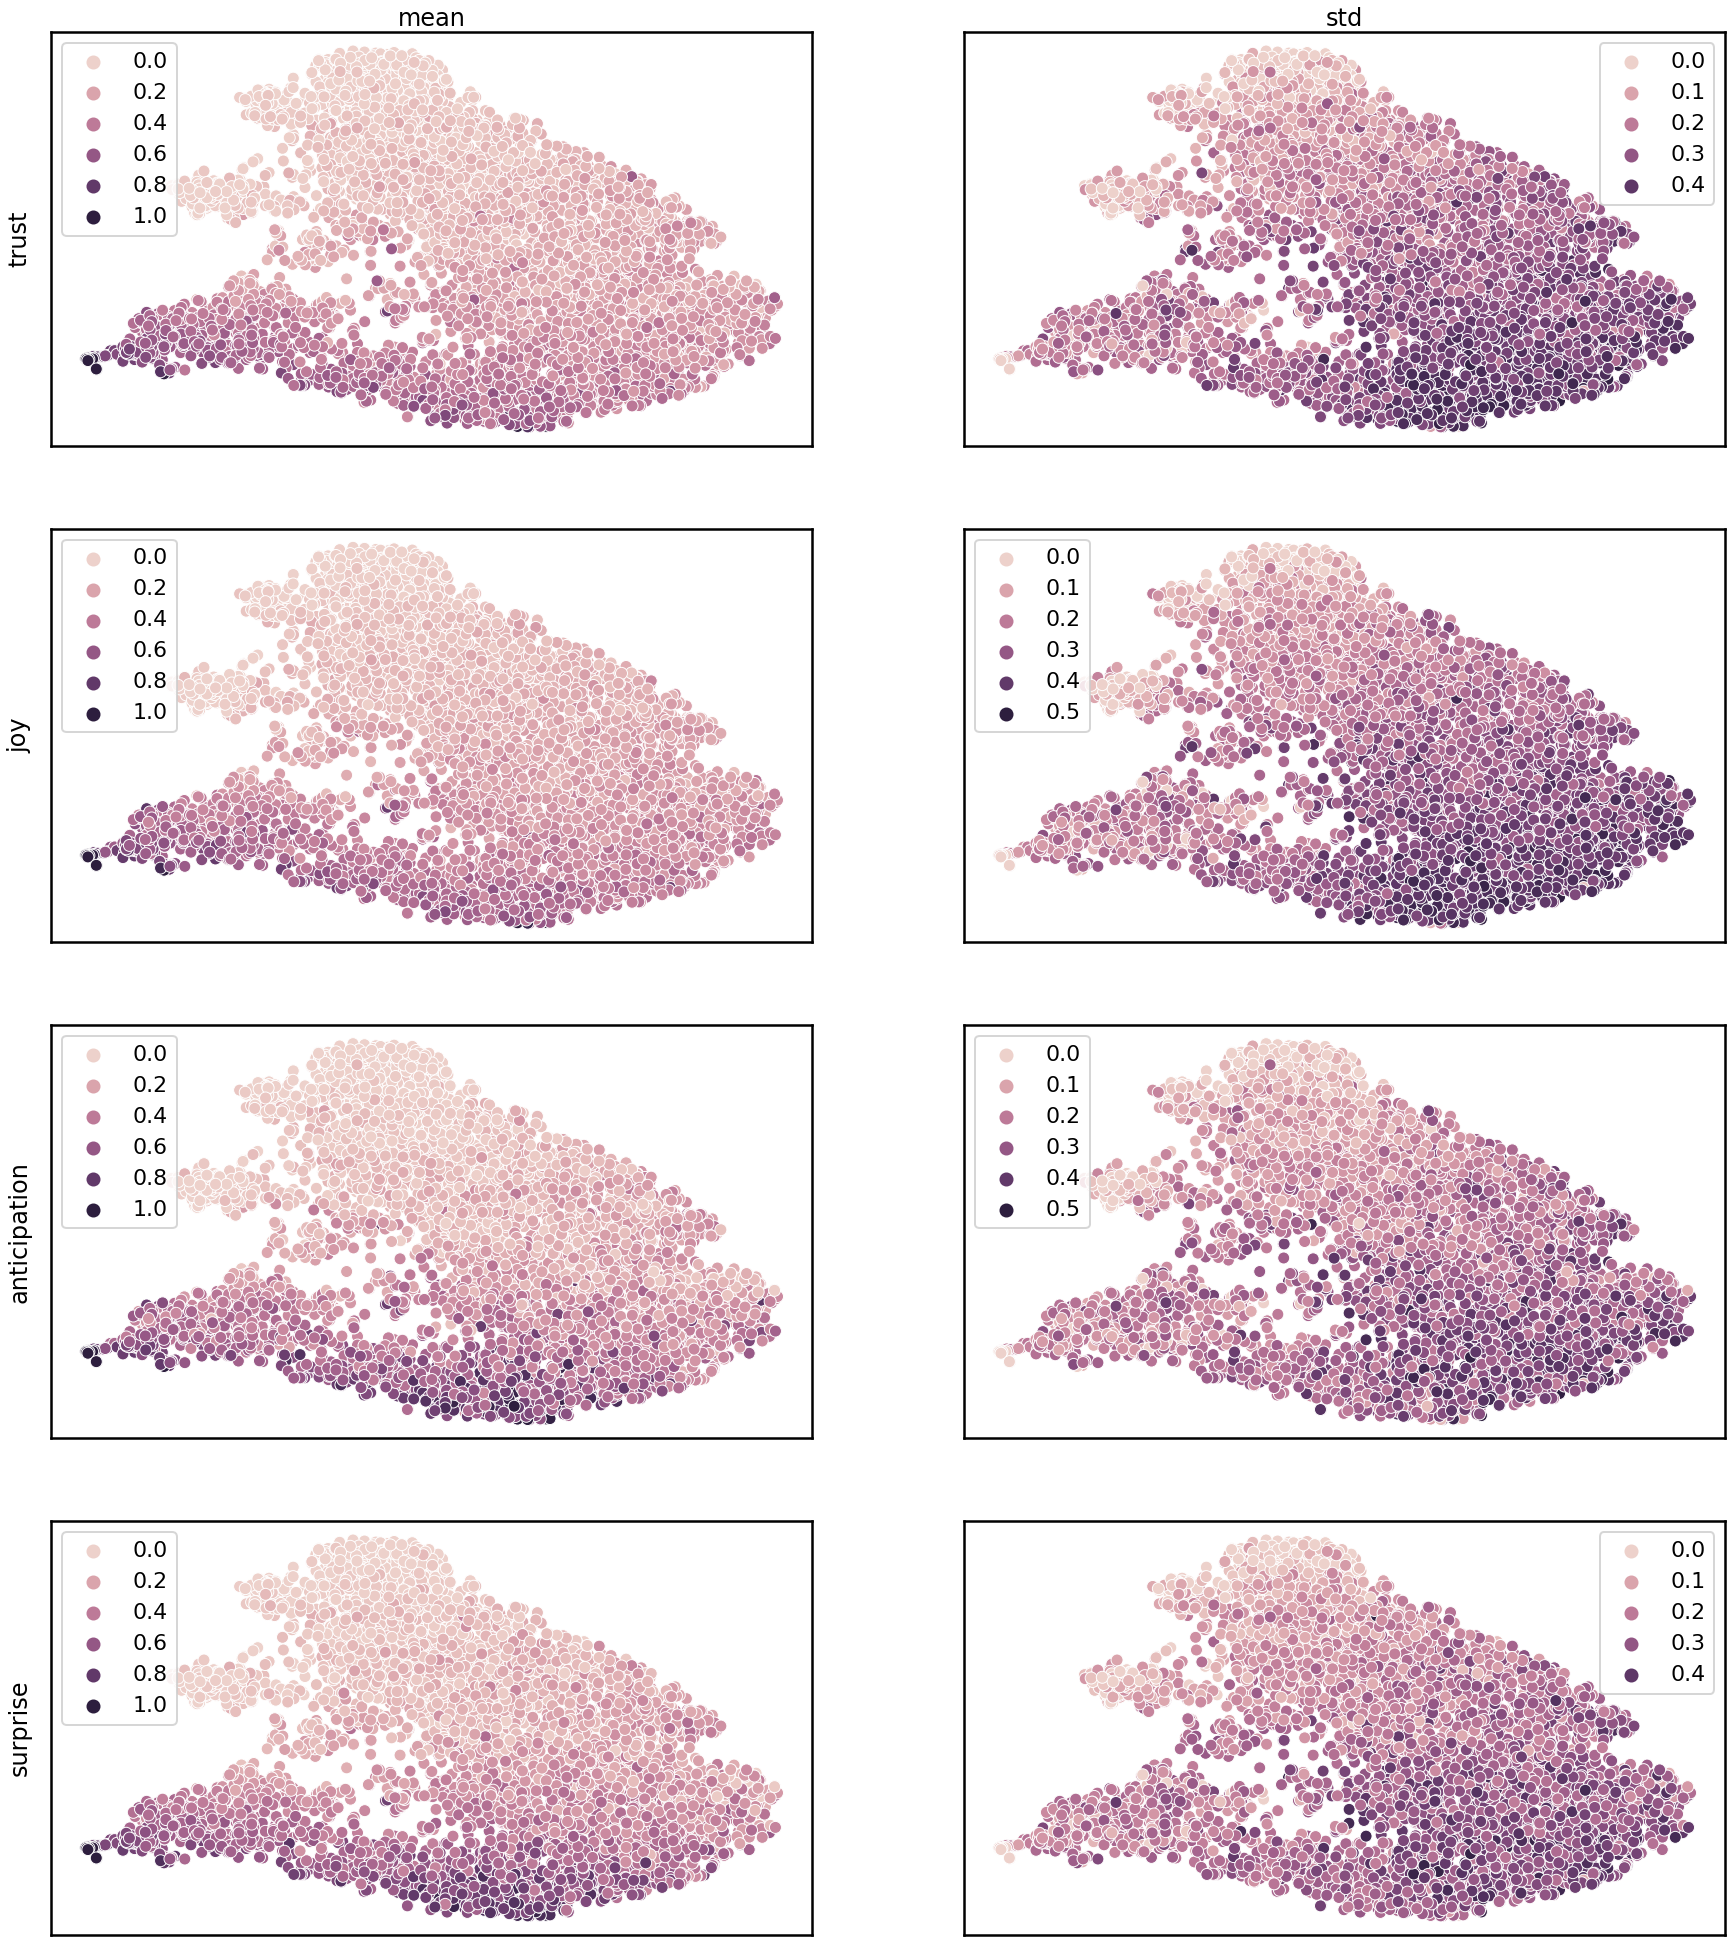

In [57]:
fig, axes = plt.subplots(4, 2, figsize=(30, 35), sharey=True)
#fig.suptitle('Embedding colored by mean and std')

for i, ax in enumerate(axes.flatten()):
    english_column = english_columns_dict[columns[i].split('_')[0]]
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    if i % 2 == 1:
        ax.set_ylabel('')
    else:
        ax.set_ylabel(english_column, labelpad=20)
        
    ax.set_xlabel('')
    if i == 0:
        ax.set_title('mean')
    elif i == 1:
        ax.set_title('std')
    
    
    sns.scatterplot(ax=ax, data=annotators_embeddings_df, x="x", y="y", hue=columns[i], legend=True)
    
    ax.legend(title='')
    
plt.savefig('positive_emotions.pdf', dpi=300)

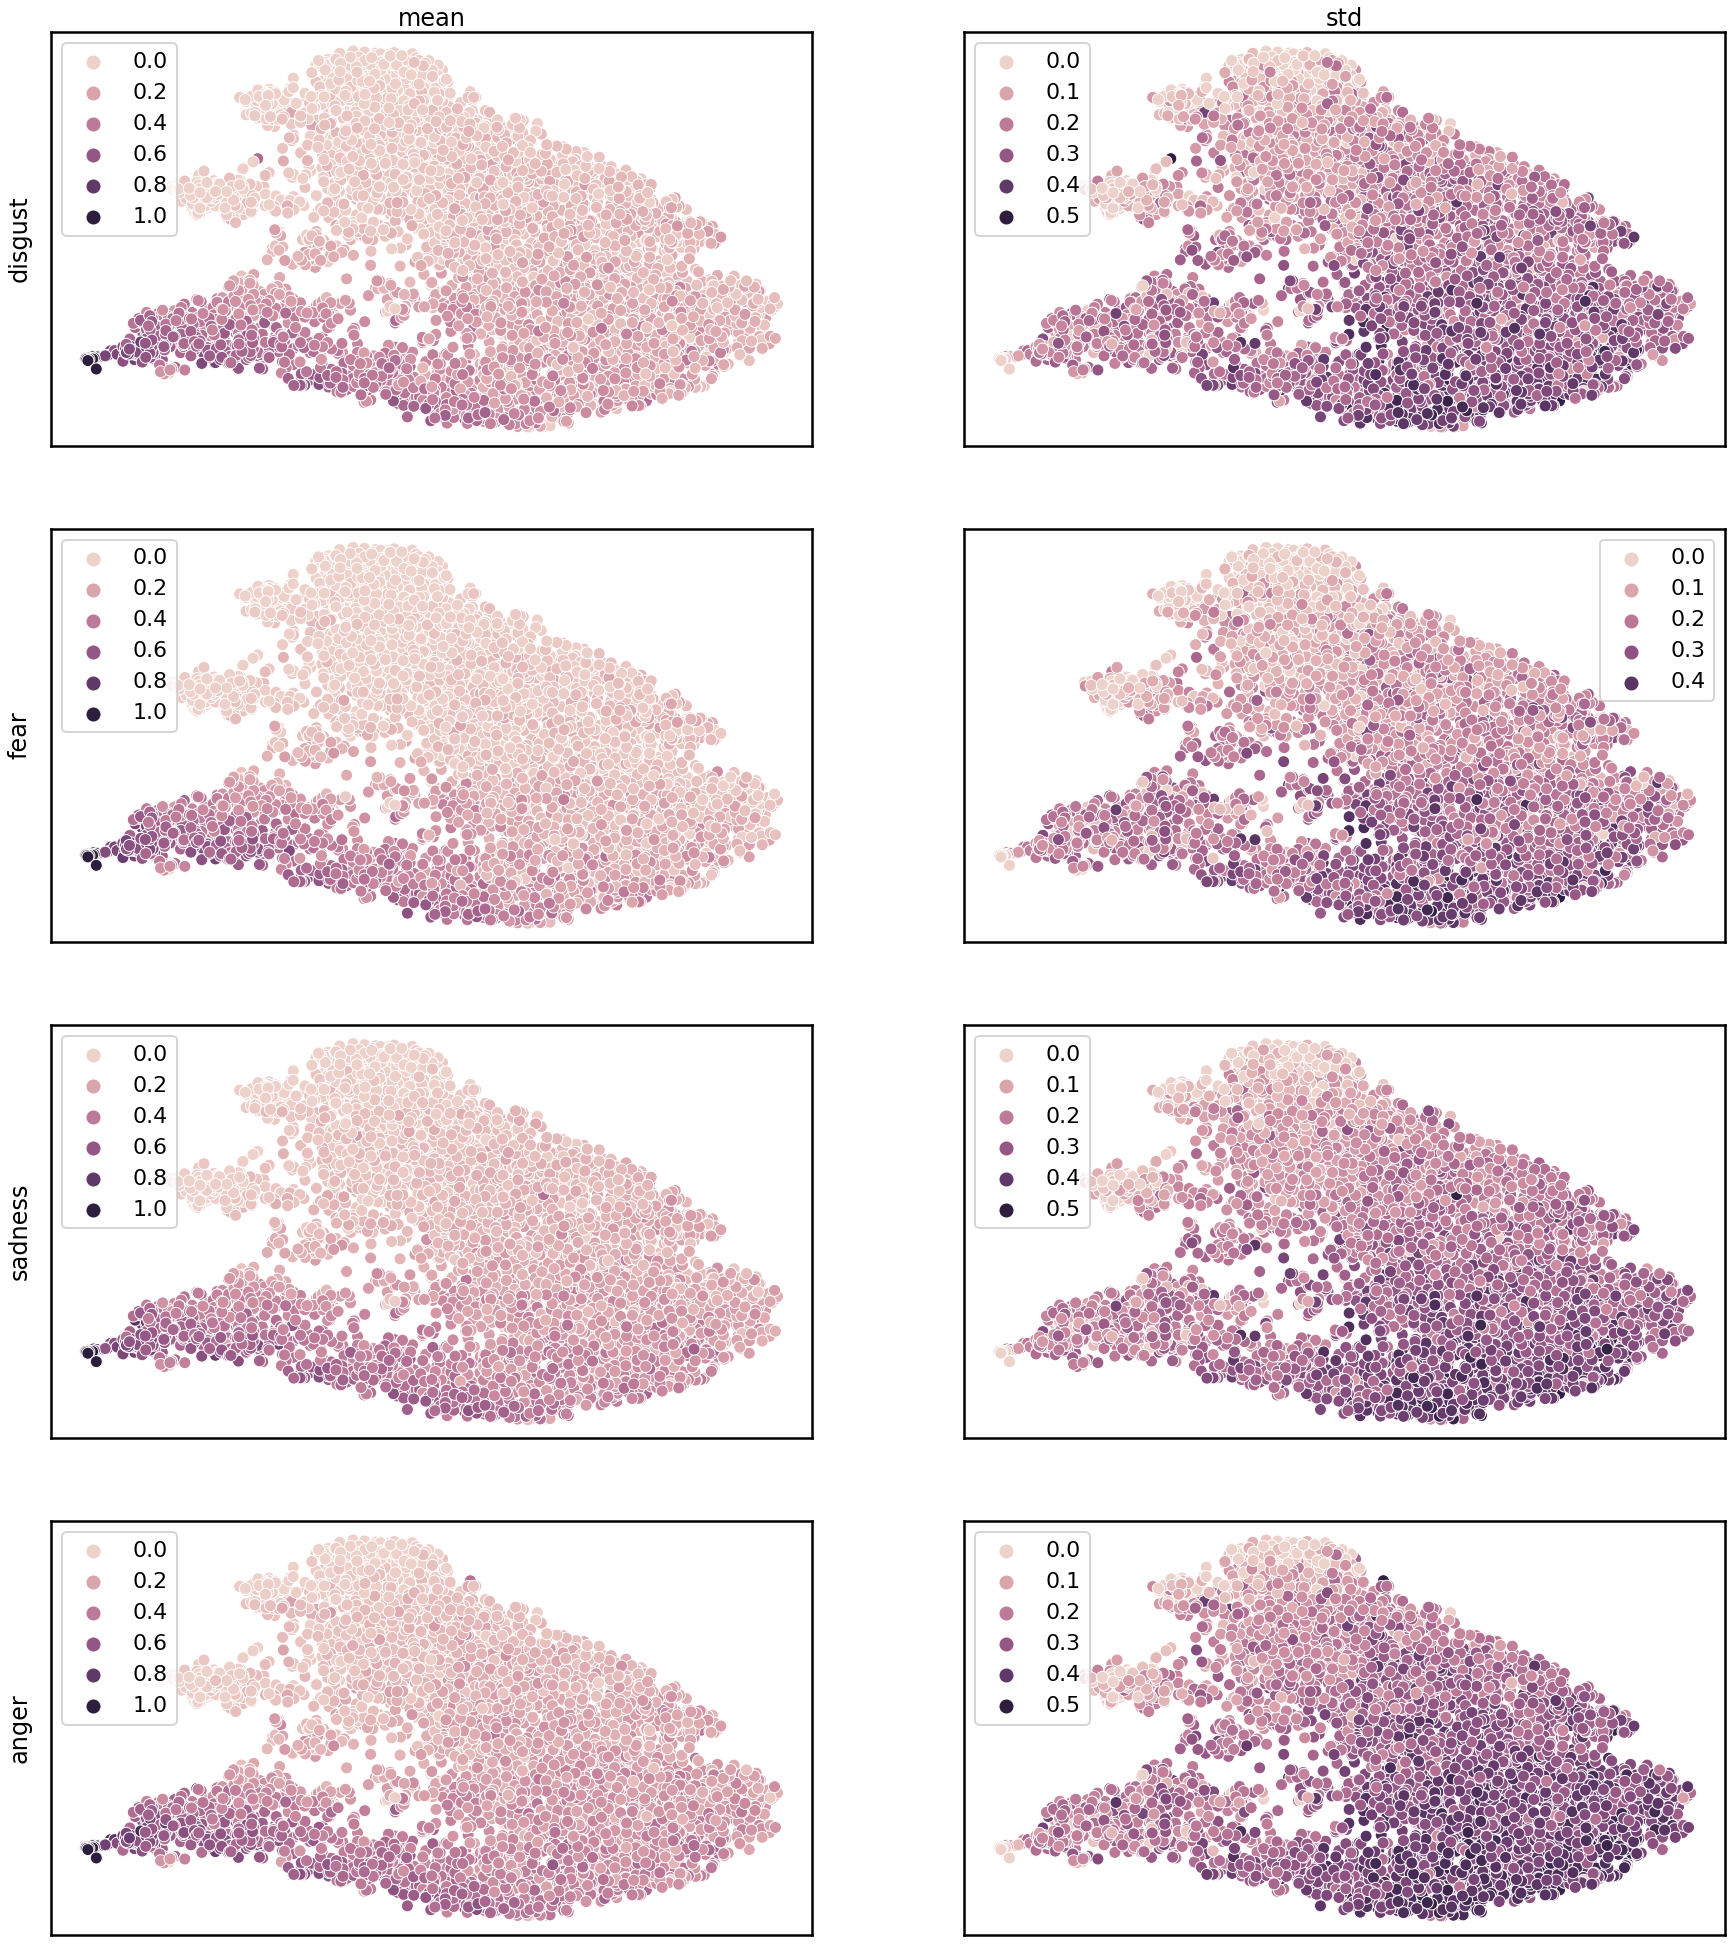

In [59]:
fig, axes = plt.subplots(4, 2, figsize=(30, 35), sharey=True)

for i, ax in enumerate(axes.flatten()):
    english_column = english_columns_dict[columns[i+8].split('_')[0]]
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    if i % 2 == 1:
        ax.set_ylabel('')
    else:
        ax.set_ylabel(english_column, labelpad=20)
        
    ax.set_xlabel('')
    if i == 0:
        ax.set_title('mean')
    elif i == 1:
        ax.set_title('std')
    
    
    sns.scatterplot(ax=ax, data=annotators_embeddings_df, x="x", y="y", hue=columns[i+8], legend=True)
    
    ax.legend(title='')
    
plt.savefig('negative_emotions.pdf', dpi=300)